In [1]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, CoreDataset, evaluate_on_test, init_weights, save_obj, load_obj

In [3]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0], parse_dates=True)

In [4]:
class FeedforwardTwoHidden(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(FeedforwardTwoHidden, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 3)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation at output layer
        return x
    

In [5]:
trainer = TrainHelper(percent = 0.99, manual = 5000, print_every=1000)

PATH = "./Core Two Layers/"

def train_times(times, trainer, net, criterion, optimizer, window):
    
    losses = []

    # train ten times, find best loss
    for i in range(times):
        net.apply(init_weights)
        print("Training %d time" % i)
        loss = trainer.train_window(net, criterion, optimizer, window)
        torch.save(net.state_dict(), PATH + "lag" + str(net.input_size//3) + "hidden" + str(net.hidden_size) + "_" + str(i) + ".pt")
        losses.append(loss)
        
    return losses

In [6]:
length = len(full.loc["1948-01-01":])
val_start = round(length * 0.8)
test_start = round(length * 0.9)    

In [8]:
losses = {}

In [13]:
hiddens = [8, 16, 24]

for lags in range(1, 15):
    coredata = CoreDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

    # subtract by lags to ensure same training sets
    trainset = Subset(coredata, [i for i in range(val_start - 1 - lags)])
    valset = Subset(coredata, [i for i in range(val_start - lags, test_start - 1 - lags)])

    trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
    validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))

    window = Window(trainloader, validationloader)
    
    for hidden_size in hiddens:
        print("Training new net, %d lags %d hidden" % (lags, hidden_size))

        net = FeedforwardTwoHidden(lags * 3, hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        loss = train_times(10, trainer, net, criterion, optimizer, window)
        print(loss)
        losses[str(lags) + "-" + str(hidden_size)] = loss
    

Training new net, 1 lags 8 hidden
Training 0 time


/Users/fredchen/JupyterProjects/macro/utils.py:351: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


[epoch: 1] train loss: 1.061, val loss: 1.131
Finished window, trained for 48 epochs, loss: 0.044
Training 1 time
[epoch: 1] train loss: 1.091, val loss: 0.956
Finished window, trained for 63 epochs, loss: 0.048
Training 2 time
[epoch: 1] train loss: 1.221, val loss: 1.412
Finished window, trained for 71 epochs, loss: 0.078
Training 3 time
[epoch: 1] train loss: 0.872, val loss: 1.216
Finished window, trained for 76 epochs, loss: 0.076
Training 4 time
[epoch: 1] train loss: 0.749, val loss: 0.714
Finished window, trained for 64 epochs, loss: 0.049
Training 5 time
[epoch: 1] train loss: 0.927, val loss: 0.919
Finished window, trained for 30 epochs, loss: 0.033
Training 6 time
[epoch: 1] train loss: 0.610, val loss: 0.921
Finished window, trained for 57 epochs, loss: 0.054
Training 7 time
[epoch: 1] train loss: 0.815, val loss: 0.837
Finished window, trained for 37 epochs, loss: 0.082
Training 8 time
[epoch: 1] train loss: 0.866, val loss: 0.665
Finished window, trained for 39 epochs, lo

In [ ]:
for k, v in losses.items():
    print(k)
    best_net_index = np.argmin(v)
    print("%.4f" % v[best_net_index])
    print("(%.4f)" % get_average(v))


In [16]:
best_loss_8 = []
avg_loss_8 = []
best_loss_16 = []
avg_loss_16 = []
best_loss_24 = []
avg_loss_24 = []

for k, v in losses.items():
    if k[1:] == str(8) or k[2:] == str(8):
        best_net_index = np.argmin(v)
        best_loss_8.append(v[best_net_index])
        avg_loss_8.append(get_average(v))
    if k[1:] == str(16) or k[2:] == str(16):
        best_net_index = np.argmin(v)
        best_loss_16.append(v[best_net_index])
        avg_loss_16.append(get_average(v))
    if k[1:] == str(24) or k[2:] == str(24):
        best_net_index = np.argmin(v)
        best_loss_24.append(v[best_net_index])
        avg_loss_24.append(get_average(v))
    
best_loss = []
avg_loss = []

for i in range(len(best_loss_8)):
    best_loss.append((best_loss_8[i] + best_loss_16[i] + best_loss_24[i]) / 3)
    avg_loss.append((avg_loss_8[i] + avg_loss_16[i] + avg_loss_24[i]) / 3)


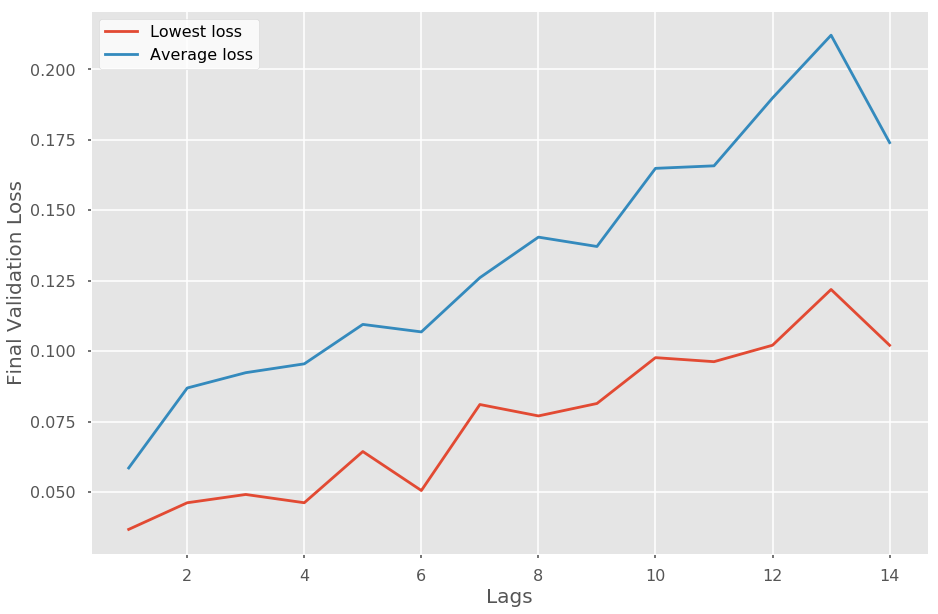

In [18]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(best_loss) + 1)], best_loss)
plt.plot([i for i in range(1, len(best_loss) + 1)], avg_loss)

plt.legend(("Lowest loss", "Average loss"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
plt.savefig('../Figs/lags_two_hidden.png', bbox_inches='tight')

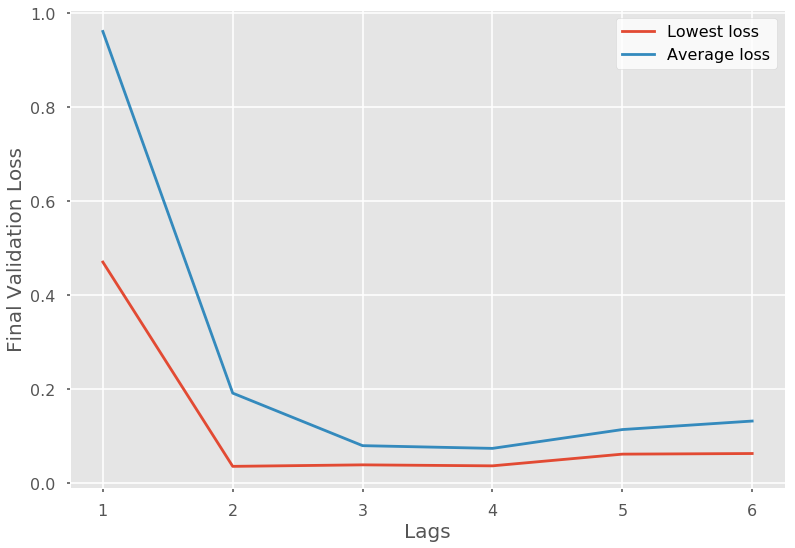

In [29]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(best_loss) + 1)], best_loss)
plt.plot([i for i in range(1, len(best_loss) + 1)], avg_loss)

plt.legend(("Lowest loss", "Average loss"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
plt.savefig('../Figs/lags_one_hidden.png', bbox_inches='tight')

In [15]:
save_obj(losses, "FF_Core_Two_Layer_Losses")

# Forecasts

In [7]:
from utils import count_parameters
from math import sqrt

In [8]:
losses = load_obj("FF_Core_Two_Layer_Losses")

In [9]:
# best model?
lowest = 100000000

for k, v in losses.items():
    best_index = np.argmin(v)
    best_loss = v[best_index]
    if best_loss < lowest:
        lowest = best_loss
        lowest_key = k
        lowest_index = best_index
        
print(lowest)
print(lowest_key)
print(lowest_index)

0.02561834941403575
18
8


In [10]:
lags = 1

testdata = CoreDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

testset = Subset(testdata, [i for i in range(test_start, length - lags)])

testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(testset))

In [11]:
criterion = nn.MSELoss()

net = FeedforwardTwoHidden(lags * 3, hidden_size=8)
net.load_state_dict(torch.load("Core Two Layers/lag1hidden8_8.pt"))

In [12]:
y_pred, mse = evaluate_on_test(testloader, net, criterion)

In [13]:
sqrt(mse)

0.13421253730497856

In [14]:
len(testloader)

84

In [16]:
save_obj(y_pred, "../Forecasts/Two_Layer_1")

In [12]:
count_parameters(net)

131

# Multi-step

In [12]:
from utils import CoreDatasetMulti

In [13]:
steps = 3

multitestdata = CoreDatasetMulti(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"], steps=steps)

multitestset = Subset(multitestdata, [i for i in range(test_start, length - lags - steps + 1)])

multitestloader = DataLoader(multitestset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(multitestset))

In [14]:
net.eval()
y_pred = []
y_act = []
running_test_loss = []

for i, data in enumerate(multitestloader):
    y, X = data
    y, X = y.float(), X.float()

    with torch.no_grad():
        forecast_1 = net(X)
        forecast_2 = net(forecast_1)
        forecast_3 = net(forecast_2)
        
        loss = criterion(y, forecast_3)
        running_test_loss.append(loss.item())
        
        y_pred.append(forecast_3.squeeze().numpy())
        y_act.append(y.squeeze().numpy())

# plt.plot(y_act)
# plt.plot(y_pred)
# plt.legend(("Test", "Forecast"), facecolor="white")
        
sqrt(get_average(running_test_loss))

0.22025457817997093

In [16]:
save_obj(y_pred, "../Forecasts/Two_Layers_3")

In [17]:
len(multitestloader)

82